## Ensure that you have relevant data in data_untracked

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from create_features import features
from path_location import folder_location

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [5]:
PROCESSED_FOLDER = folder_location.PROCESSED_DATA_FOLDER
FEATURES_FILE = folder_location.FULL_FEATURES_FILE
data = pd.read_csv(f'{PROCESSED_FOLDER}/{FEATURES_FILE}')
print(data.shape)
data.head()

(1786525, 86)


,TRANS_SK,ACCESSION_NUMBER,TRANS_DATE,TRANS_CODE,ISSUERTRADINGSYMBOL,RPTOWNERNAME_;,snorkel_prob,y_pred,ppr_topK_exp,num_topK_neighbors,ppr_house_0.85,ppr_house_0.95,ppr_senate_0.85,ppr_senate_0.95,is_lobby,has_lobby,has_donate,NODEID,important_connections,full_congress_connections,house_t2_important_connections,house_t2_full_congress_connections,house_t1_important_connections,house_t1_full_congress_connections,sen_important_connections,sen_full_congress_connections,sen_t2_important_connections,sen_t2_full_congress_connections,sen_t1_important_connections,sen_t1_full_congress_connections,full_congress_connections_z,sen_full_congress_connections_z,sen_t2_full_congress_connections_z,house_t2_full_congress_connections_z,sen_important_connections_z,sen_t2_important_connections_z,important_connections_z,house_t2_important_connections_z,full_congress_connections_z_cat,full_congress_connections_z_is_low,full_congress_connections_z_is_high,sen_full_congress_connections_z_cat,sen_full_congress_connections_z_is_low,sen_full_congress_connections_z_is_high,sen_t2_full_congress_connections_z_cat,sen_t2_full_congress_connections_z_is_low,sen_t2_full_congress_connections_z_is_high,house_t2_full_congress_connections_z_cat,house_t2_full_congress_connections_z_is_low,house_t2_full_congress_connections_z_is_high,sen_important_connections_z_cat,sen_important_connections_z_is_low,sen_important_connections_z_is_high,sen_t2_important_connections_z_cat,sen_t2_important_connections_z_is_low,sen_t2_important_connections_z_is_high,important_connections_z_cat,important_connections_z_is_low,important_connections_z_is_high,house_t2_important_connections_z_cat,house_t2_important_connections_z_is_low,house_t2_important_connections_z_is_high,js_bin,s_bin,b_bin,jb_bin,ob_bin,gb_bin,gift,distribution,charity,price,number,ball,pursuant,10b5-1,16b-3,net_trading_intensity,net_trading_amt,relative_trade_size_to_self,beneficial_ownership_score,title_score,TRANS_TIMELINESS_clean,execution_timeliness,filing_lag_days,filing_timeliness
0,3794004,0001181431-09-023155,2009-05-04,S,EXAC,BINCH JAMES G,1.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,89,333,169,430,0,1,28,21,23,18,0,0,0.876972,1.034541,10.110444,10.861257,0.858930,0.636379,0.276601,4.883349,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.000000,0,0,on_time,on_trans,2,late_filing
1,2834113,0001181431-12-005367,2012-01-31,S,EXAC,BINCH JAMES G,1.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,332,160,423,0,0,88,97,89,98,0,0,0.404706,0.808893,5.176332,7.904903,1.455074,3.301745,0.850979,3.931007,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,2.061856,0,0,on_time,on_trans,2,late_filing
2,3043733,0001181431-12-047732,2012-08-03,S,EXAC,BINCH JAMES G,0.090053,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,326,160,423,0,0,88,97,89,98,0,0,0.342856,0.742962,6.120190,7.866274,1.103764,4.298150,0.388136,4.986063,medium,0.0,0.0,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.959596,0,0,on_time,on_trans,25,late_filing
3,3043734,0001181431-12-047732,2012-08-07,S,EXAC,BINCH JAMES G,0.090053,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,326,196,426,1,1,88,97,82,98,0,1,0.342856,0.742962,6.120190,7.866274,1.103764,4.298150,0.388136,4.986063,medium,0.0,0.0,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.788055,0,0,on_time,on_trans,21,late_filing
4,3043284,0001181431-12-049839,2012-09-07,S,EXAC,BINCH JAMES G,0.219855,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,325,173,426,1,1,88,97,82,98,0,1,0.423546,0.778610,3.223034,4.816225,1.702611,2.244395,1.451735,3

___
## Load data
___

In [2]:
features = features.FEATURES
print(features)

['js_bin', 's_bin', 'b_bin', 'jb_bin', 'ob_bin', 'gb_bin', 'gift', 'distribution', 'charity', 'price', 'number', 'ball', 'pursuant', '10b5-1', '16b-3', 'net_trading_intensity', 'net_trading_amt', 'relative_trade_size_to_self', 'beneficial_ownership_score', 'title_score', 'TRANS_TIMELINESS_clean', 'execution_timeliness', 'filing_lag_days', 'filing_timeliness', 'is_lobby', 'has_lobby', 'has_donate', 'NODEID', 'important_connections', 'full_congress_connections', 'house_t2_important_connections', 'house_t2_full_congress_connections', 'house_t1_important_connections', 'house_t1_full_congress_connections', 'sen_important_connections', 'sen_full_congress_connections', 'sen_t2_important_connections', 'sen_t2_full_congress_connections', 'sen_t1_important_connections', 'sen_t1_full_congress_connections', 'full_congress_connections_z', 'sen_full_congress_connections_z', 'sen_t2_full_congress_connections_z', 'house_t2_full_congress_connections_z', 'sen_important_connections_z', 'sen_t2_important_

In [3]:
PROCESSED_FOLDER = folder_location.PROCESSED_DATA_FOLDER
FEATURES_FILE = folder_location.FULL_FEATURES_FILE
data = pd.read_csv(f'{PROCESSED_FOLDER}/{FEATURES_FILE}', parse_dates=['TRANS_DATE'])
print(data.shape)
data.head()

(1786525, 86)


,TRANS_SK,ACCESSION_NUMBER,TRANS_DATE,TRANS_CODE,ISSUERTRADINGSYMBOL,RPTOWNERNAME_;,snorkel_prob,y_pred,ppr_topK_exp,num_topK_neighbors,ppr_house_0.85,ppr_house_0.95,ppr_senate_0.85,ppr_senate_0.95,is_lobby,has_lobby,has_donate,NODEID,important_connections,full_congress_connections,house_t2_important_connections,house_t2_full_congress_connections,house_t1_important_connections,house_t1_full_congress_connections,sen_important_connections,sen_full_congress_connections,sen_t2_important_connections,sen_t2_full_congress_connections,sen_t1_important_connections,sen_t1_full_congress_connections,full_congress_connections_z,sen_full_congress_connections_z,sen_t2_full_congress_connections_z,house_t2_full_congress_connections_z,sen_important_connections_z,sen_t2_important_connections_z,important_connections_z,house_t2_important_connections_z,full_congress_connections_z_cat,full_congress_connections_z_is_low,full_congress_connections_z_is_high,sen_full_congress_connections_z_cat,sen_full_congress_connections_z_is_low,sen_full_congress_connections_z_is_high,sen_t2_full_congress_connections_z_cat,sen_t2_full_congress_connections_z_is_low,sen_t2_full_congress_connections_z_is_high,house_t2_full_congress_connections_z_cat,house_t2_full_congress_connections_z_is_low,house_t2_full_congress_connections_z_is_high,sen_important_connections_z_cat,sen_important_connections_z_is_low,sen_important_connections_z_is_high,sen_t2_important_connections_z_cat,sen_t2_important_connections_z_is_low,sen_t2_important_connections_z_is_high,important_connections_z_cat,important_connections_z_is_low,important_connections_z_is_high,house_t2_important_connections_z_cat,house_t2_important_connections_z_is_low,house_t2_important_connections_z_is_high,js_bin,s_bin,b_bin,jb_bin,ob_bin,gb_bin,gift,distribution,charity,price,number,ball,pursuant,10b5-1,16b-3,net_trading_intensity,net_trading_amt,relative_trade_size_to_self,beneficial_ownership_score,title_score,TRANS_TIMELINESS_clean,execution_timeliness,filing_lag_days,filing_timeliness
0,3794004,0001181431-09-023155,2009-05-04,S,EXAC,BINCH JAMES G,1.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,89,333,169,430,0,1,28,21,23,18,0,0,0.876972,1.034541,10.110444,10.861257,0.858930,0.636379,0.276601,4.883349,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.000000,0,0,on_time,on_trans,2,late_filing
1,2834113,0001181431-12-005367,2012-01-31,S,EXAC,BINCH JAMES G,1.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,332,160,423,0,0,88,97,89,98,0,0,0.404706,0.808893,5.176332,7.904903,1.455074,3.301745,0.850979,3.931007,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,2.061856,0,0,on_time,on_trans,2,late_filing
2,3043733,0001181431-12-047732,2012-08-03,S,EXAC,BINCH JAMES G,0.090053,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,326,160,423,0,0,88,97,89,98,0,0,0.342856,0.742962,6.120190,7.866274,1.103764,4.298150,0.388136,4.986063,medium,0.0,0.0,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.959596,0,0,on_time,on_trans,25,late_filing
3,3043734,0001181431-12-047732,2012-08-07,S,EXAC,BINCH JAMES G,0.090053,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,326,196,426,1,1,88,97,82,98,0,1,0.342856,0.742962,6.120190,7.866274,1.103764,4.298150,0.388136,4.986063,medium,0.0,0.0,medium,0.0,0.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,high,0.0,1.0,medium,0.0,0.0,high,0.0,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.788055,0,0,on_time,on_trans,21,late_filing
4,3043284,0001181431-12-049839,2012-09-07,S,EXAC,BINCH JAMES G,0.219855,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,249380.0,95,325,173,426,1,1,88,97,82,98,0,1,0.423546,0.778610,3.223034,4.816225,1.702611,2.244395,1.451735,3

___
## Quick Visualisations
___

### We see that the non suspicious trades have about 2 million counts while the suspicious trades are at about 1.25 million. This is a 60:40 ratio, which makes our dataset quite balanced 

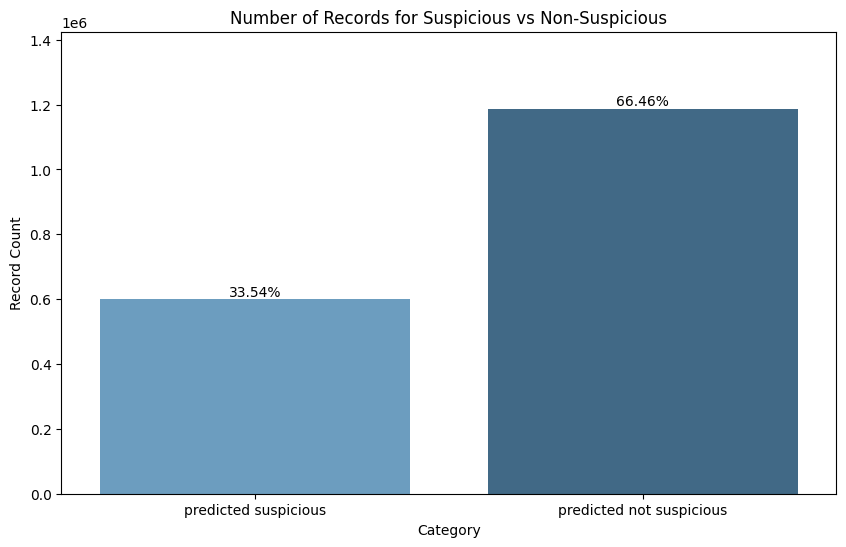

In [4]:
count1, count0 = sum(data["y_pred"] == 1), sum(data["y_pred"] == 0)

categories = ["predicted suspicious", "predicted not suspicious"]
value = [count1, count0]

plt.figure(figsize=(10,6))
# Create the barplot
ax = sns.barplot(x=categories, y=value, palette="Blues_d")
# Add percentage labels on top of the bars
for i, v in enumerate(value):
    ax.text(i, v + 0.01, f"{(v*100)/data.shape[0]:1.2f}%", ha='center', va='bottom')
plt.ylim(0, max(value) * 1.2)
plt.xlabel('Category')
plt.ylabel('Record Count')
plt.title('Number of Records for Suspicious vs Non-Suspicious')
plt.show()

### Lets see the distribution of insider transaction by time

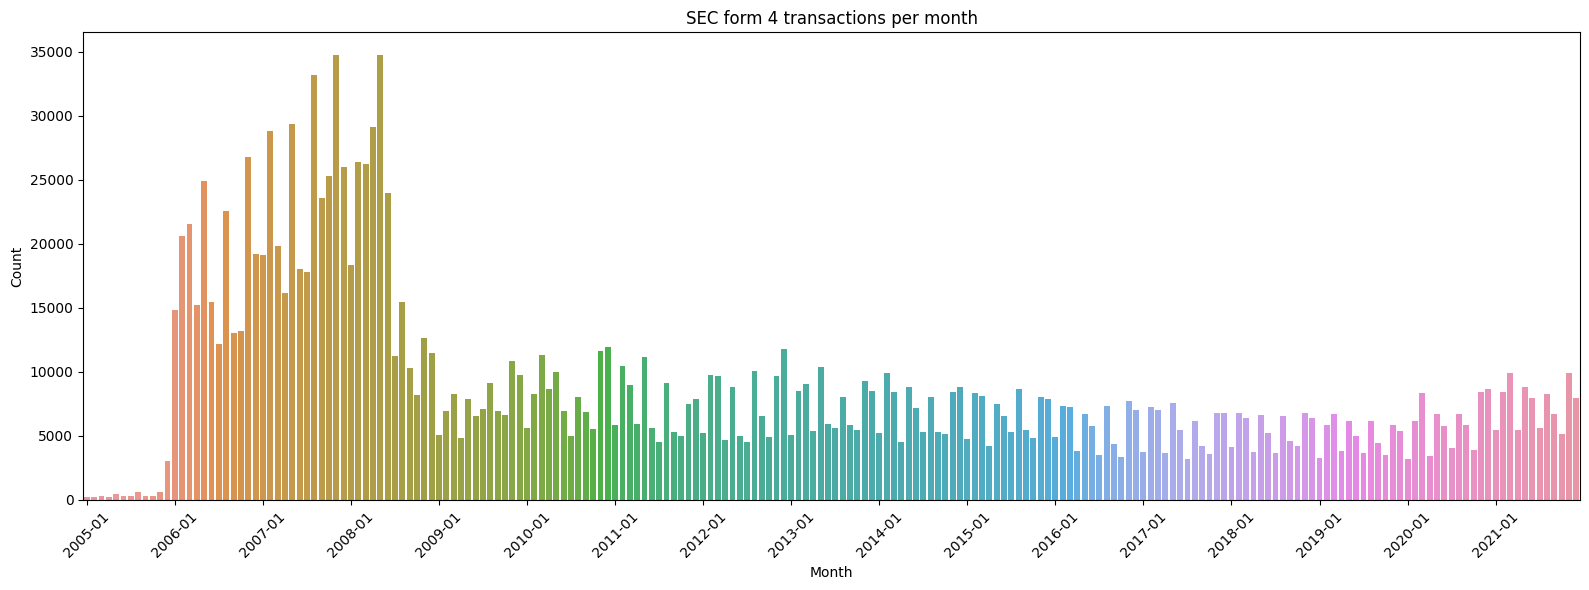

In [5]:
monthly_counts = data['TRANS_DATE'].dt.to_period('M').value_counts().sort_index()

# Convert period to string or datetime for plotting
monthly_counts.index = monthly_counts.index.astype(str)

# Plot
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=monthly_counts.index, y=monthly_counts)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::12])
# monthly_counts.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('SEC form 4 transactions per month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

___
## CAR hypothesis - does CAR before and after fit our expectations?
___

In [7]:
abnormal = folder_location.TRANSACTIONS_ABNORMAL_FILE
abnormal_features = pd.read_csv(f'{PROCESSED_FOLDER}/{abnormal}')

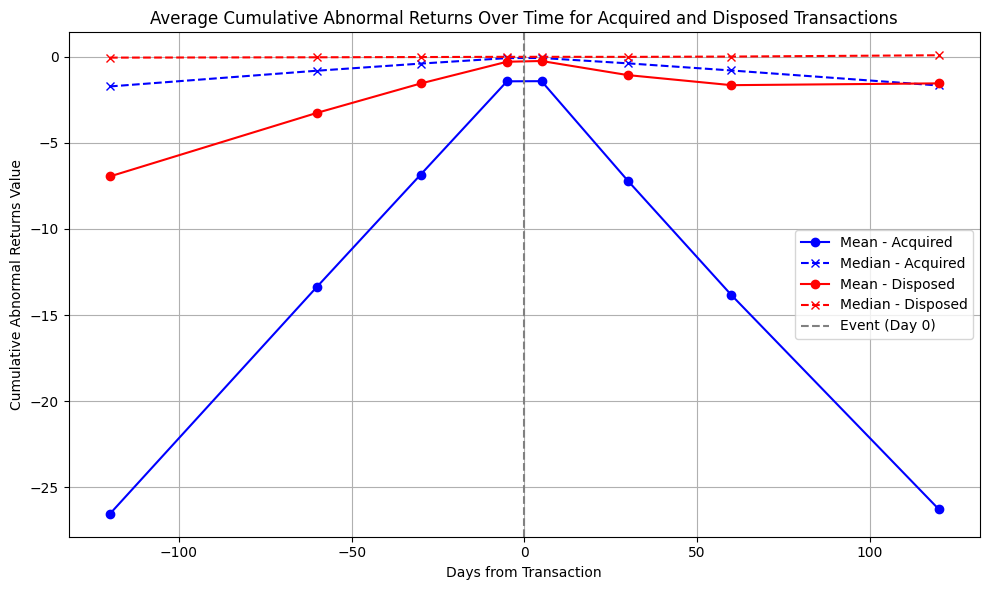

In [8]:
# Define CAR columns and their mapping to time points
car_cols = [
    'CAR_120_before', 'CAR_60_before', 'CAR_30_before', 'CAR_5_before',
    'CAR_5_after', 'CAR_30_after', 'CAR_60_after', 'CAR_120_after'
]
time_map = {'CAR_120_before': -120, 'CAR_60_before': -60, 'CAR_30_before': -30, 'CAR_5_before': -5, 
            'CAR_5_after': 5, 'CAR_30_after': 30, 'CAR_60_after': 60, 'CAR_120_after': 120}

# Filter for A and D groups
group_a = abnormal_features[abnormal_features['TRANS_ACQUIRED_DISP_CD'] == 'A']
group_d = abnormal_features[abnormal_features['TRANS_ACQUIRED_DISP_CD'] == 'D']
# Compute means and medians
means_a = group_a[car_cols].mean().rename(time_map).sort_index()
medians_a = group_a[car_cols].median().rename(time_map).sort_index()
means_d = group_d[car_cols].mean().rename(time_map).sort_index()
medians_d = group_d[car_cols].median().rename(time_map).sort_index()

# Plot
plt.figure(figsize=(10, 6))

plt.plot(means_a.index, means_a.values, label='Mean - Acquired', color='blue', marker='o', linestyle='-')
plt.plot(medians_a.index, medians_a.values, label='Median - Acquired', color='blue', marker='x', linestyle='--')
plt.plot(means_d.index, means_d.values, label='Mean - Disposed', color='red', marker='o', linestyle='-')
plt.plot(medians_d.index, medians_d.values, label='Median - Disposed', color='red', marker='x', linestyle='--')

# Styling
plt.axvline(0, color='gray', linestyle='--', label='Event (Day 0)')
plt.title("Average Cumulative Abnormal Returns Over Time for Acquired and Disposed Transactions")
plt.xlabel("Days from Transaction")
plt.ylabel("Cumulative Abnormal Returns Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

___
## Hypothesis Testing for feature signficance
___

In [4]:
## Define Constants
LABEL = 'y_pred' 

In [6]:
def compare_complement(df, col, metrics):

    ## we assume normal distribution due to the large sample size
    split_1 = df[df[col] == 1]
    split_2 = df[df[col] != 1]

    t_stats = []
    p_vals = []
    split_1_means = []
    split_2_means = []

    for metric in metrics:
        A = split_1[metric].dropna()
        B = split_2[metric].dropna()

        # Welch's t-test
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)

        t_stats.append(round(t_stat, 3))
        p_vals.append(round(p_val, 3))
        split_1_means.append(round(np.mean(A), 3))
        split_2_means.append(round(np.mean(B), 3))

    dataframe = pd.DataFrame({'column':metrics,'t-statistic': t_stats, 'p-value': p_vals})
    dataframe['significant?'] = dataframe['p-value'].apply(lambda x: 'yes' if x < 0.05 else 'no')
    return dataframe

def is_continuous(series, threshold_unique=10):
    """Check if a numeric series is likely continuous."""
    if not pd.api.types.is_numeric_dtype(series):
        return False
    # Too few unique values → probably categorical
    if series.nunique() <= threshold_unique:
        return False
    return True

# Apply features
numeric_features = [f for f in features if is_continuous(data[f])]
table = compare_complement(data, "y_pred", numeric_features)
table

,column,t-statistic,p-value,significant?
0,gift,59.524,0.000,yes
1,distribution,-22.974,0.000,yes
2,price,-35.615,0.000,yes
3,number,-18.085,0.000,yes
4,ball,-26.318,0.000,yes
5,pursuant,-47.379,0.000,yes
6,10b5-1,-40.706,0.000,yes
7,16b-3,10.216,0.000,yes
8,net_trading_intensity,-53.956,0.000,yes
9,net_trading_amt,-40.217,0.000,yes


In [9]:
## I HAVE NO IDEA WHY "relative_trade_size_to_self" IS NA WHEN RAN IN THE FUNCTION.. 
col = "relative_trade_size_to_self"
metric = 'y_pred'
split_1 = data[data[col] == 1]
split_2 = data[data[col] != 1]
A = split_1[metric].dropna()
B = split_2[metric].dropna()

# Welch's t-test
t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
print(t_stat, p_val)

28.867314071123154 2.438743613994225e-182


In [11]:
table = compare_complement(data, "y_pred", ["relative_trade_size_to_self"])

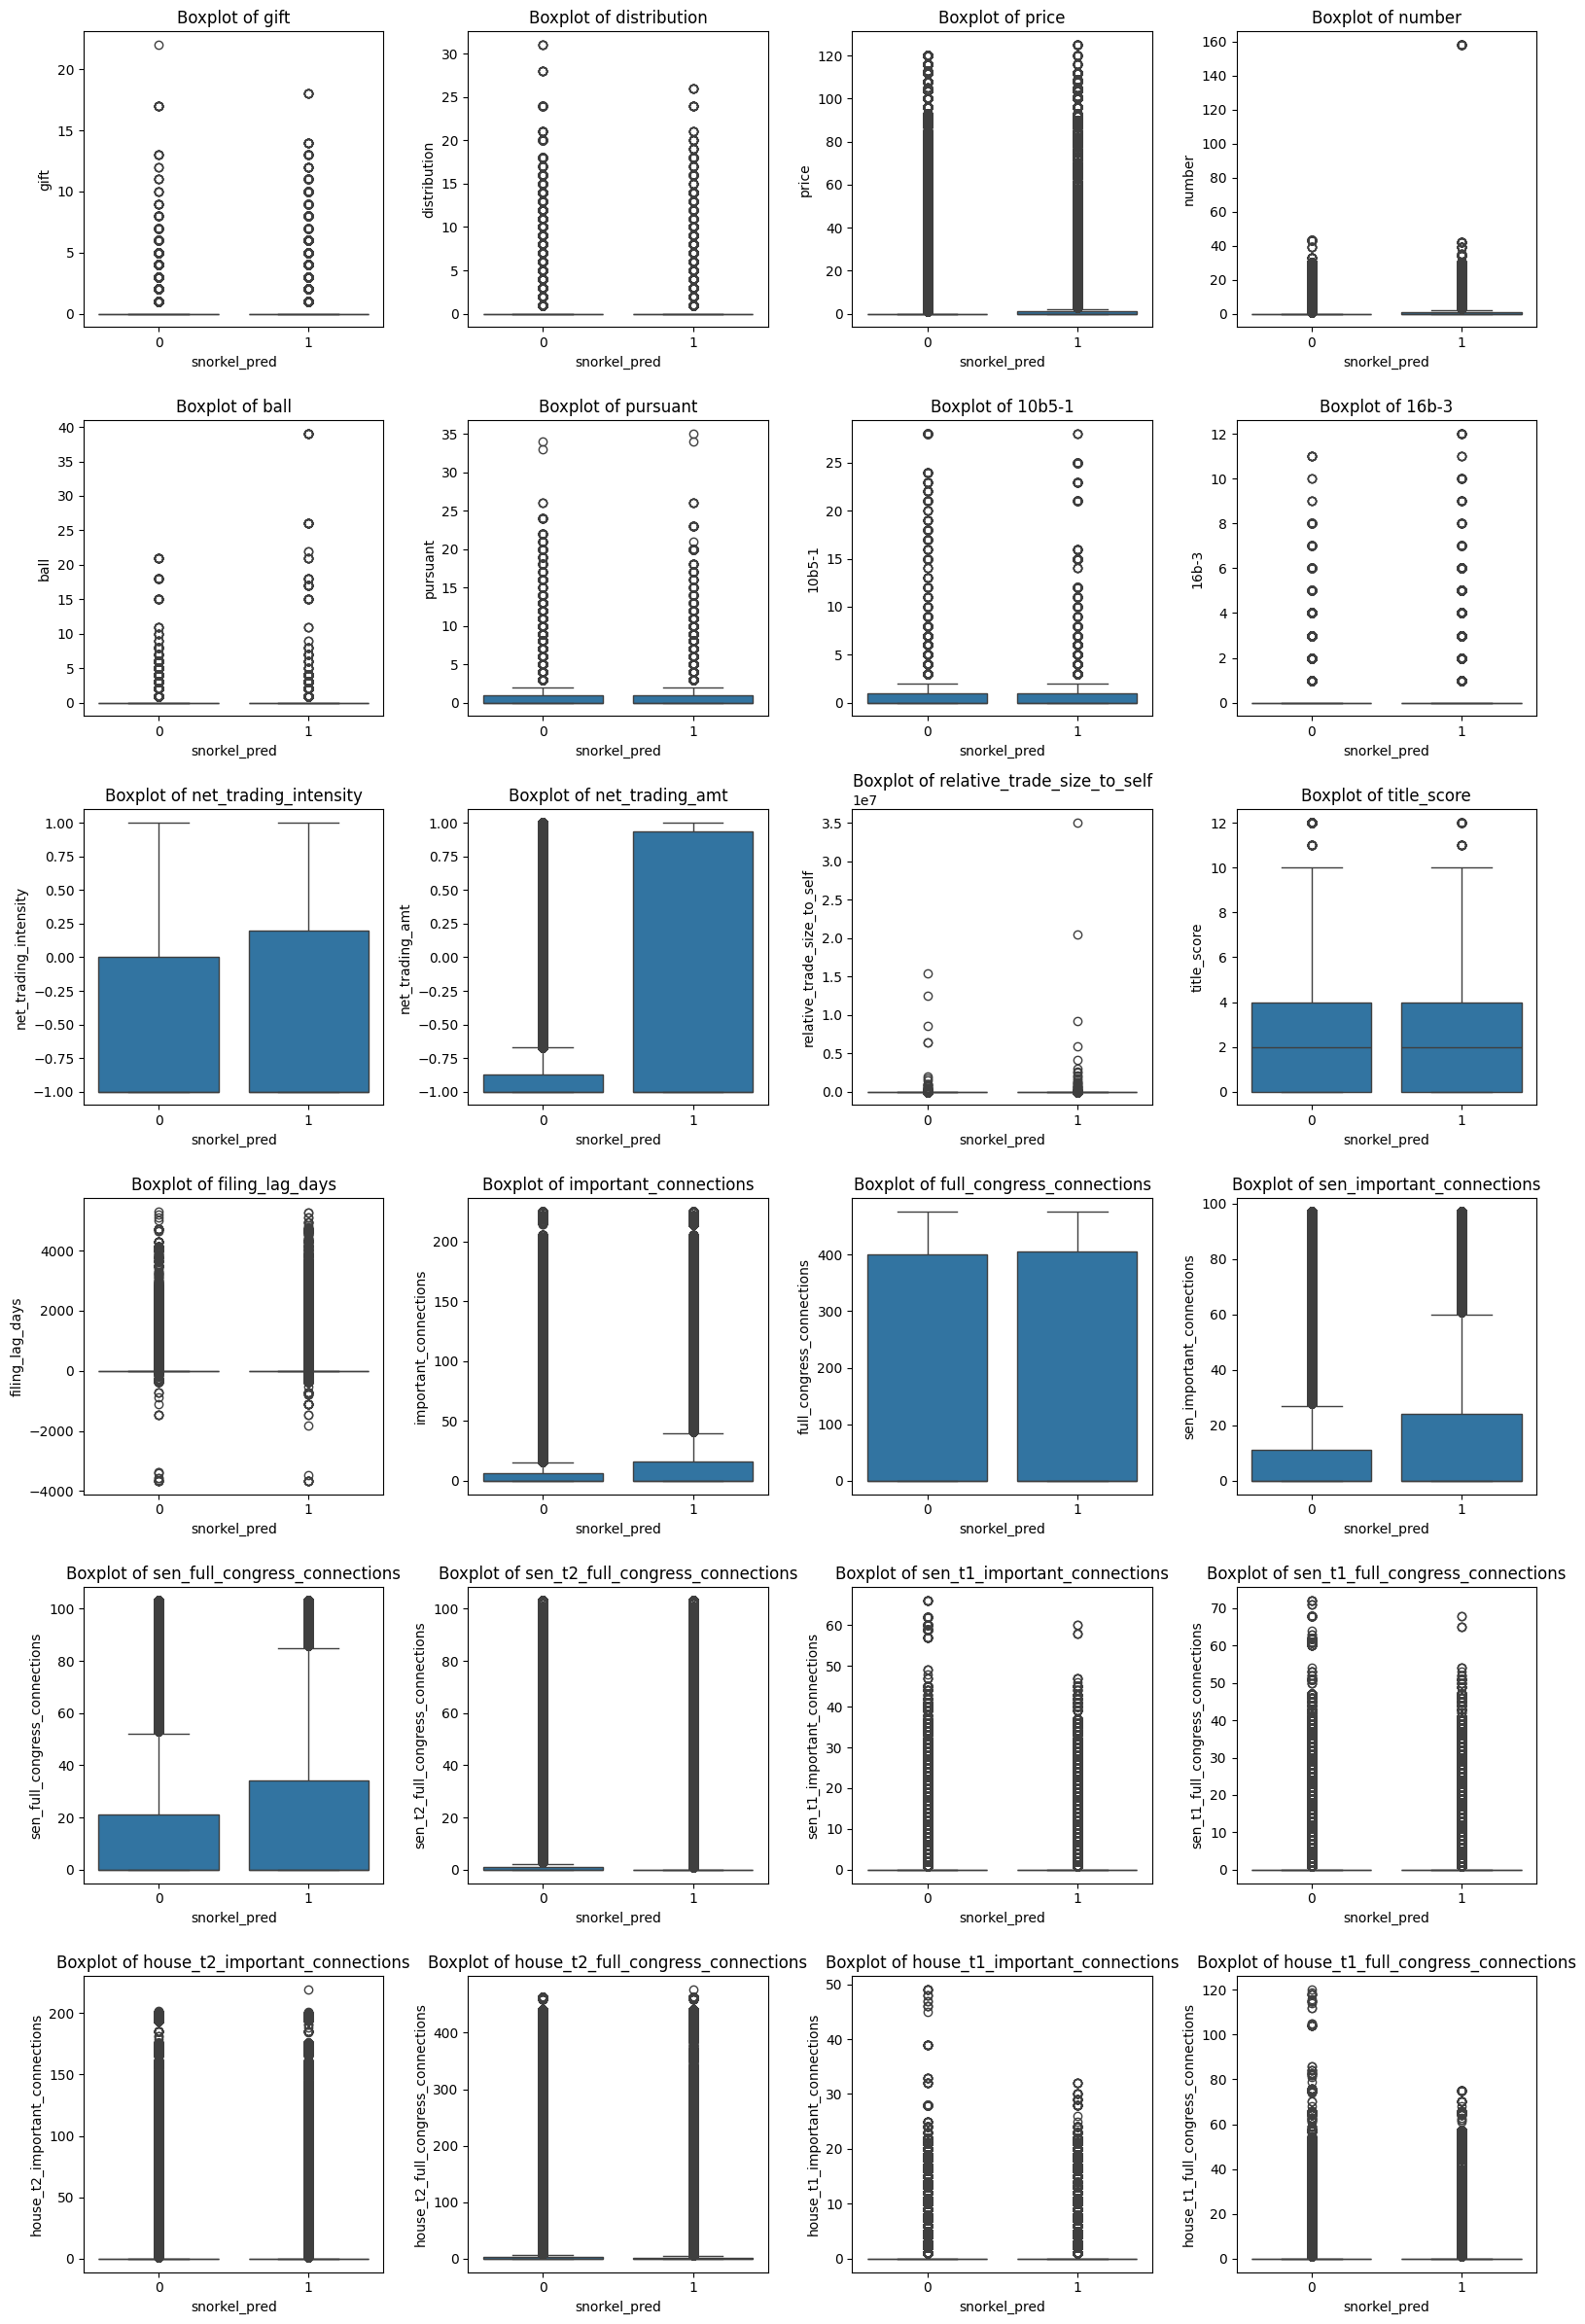

In [ ]:
# Grid size: square-ish layout
n_features = len(numeric_features)
n_cols = int(n_features**0.5)
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

# Plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    sns.boxplot(x='snorkel_pred', y=feature, data=data, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {feature}')
    axes[idx].set_xlabel('snorkel_pred')
    axes[idx].set_ylabel(feature)

# Hide any unused subplots
for ax in axes[len(numeric_features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()